# gpOptimizer: Single-Task Acquisition Functions

In [1]:
#!pip install gpcam==8.2.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time
from loguru import logger
from distributed import Client
client = Client()


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Preparation

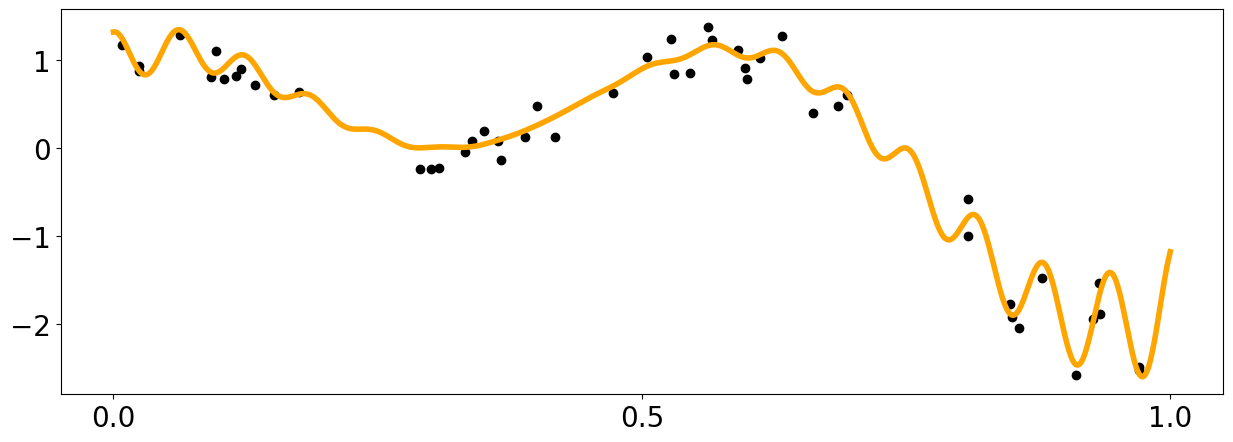

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(50).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

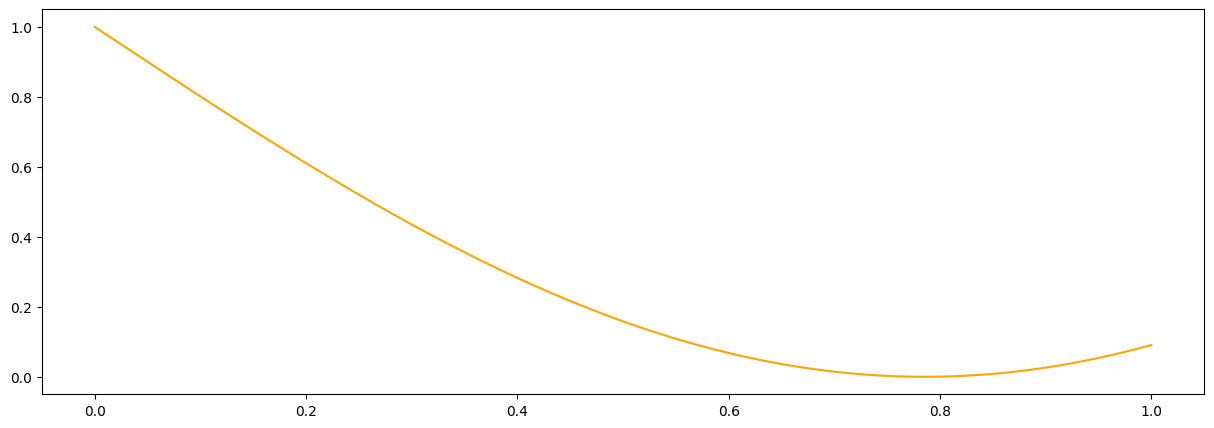

In [5]:
def my_noise(x,hps):
    #This is a simple noise function but can be made arbitrarily complex using many hyperparameters.
    #The noise function can return a matrix or a vector 
    return np.zeros((len(x))) + hps[2]

#stationary
from gpcam.kernels import *
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This is a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return 1.-np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [6]:


my_gpo = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions 
            compute_device='cpu', 
            kernel_function=skernel, 
            kernel_function_grad=None, 
            prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            noise_function=my_noise,
            #noise_variances=np.zeros(y_data.shape) + 0.1,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args={'a': 1.5, 'b':2.},
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.00001,0.1],  #noise
                       [0.00001,1.]  #mean
                      ])

my_gpo.tell(x_data, y_data, append=True) ##every data entry twice
my_gpo.tell(x_data, y_data, append=False) ## back to normal overwriting the data


print("Standard Training (=MCMC)")
my_gpo.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='global', info=True, max_iter=2)
print("hps: ", my_gpo.get_hyperparameters())
print("Local Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='local', info=True)
print(my_gpo.get_hyperparameters())
print("MCMC Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=10, info=True)
print("HGDL Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10, dask_client=client)


Standard Training (=MCMC)
Global Training
differential_evolution step 1: f(x)= 18.639916242301965
differential_evolution step 2: f(x)= 18.639916242301965
hps:  [2.46109227 0.34888268 0.06514301 0.5991155 ]
Local Training
[2.50032997 0.38739583 0.06053467 1.        ]
MCMC Training
HGDL Training


array([2.28551063, 0.37304877, 0.06051735, 1.        ])

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [9]:
my_gpo.set_hyperparameters(np.ones((4))/10.)
opt_obj = my_gpo.train_async(hyperparameter_bounds=hps_bounds, dask_client=client)
print(my_gpo.get_hyperparameters())
for i in range(10):
    time.sleep(0.1)
    my_gpo.update_hyperparameters(opt_obj)
    print(my_gpo.get_hyperparameters())
    time.sleep(0.1)

my_gpo.stop_training(opt_obj)

[0.1 0.1 0.1 0.1]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]
[2.28548867 0.37304824 0.06051729 1.        ]


## Vizualizing the Results

0.21153120936336084
(np.float64(1.051003762217801), np.float64(0.9585932911182051))


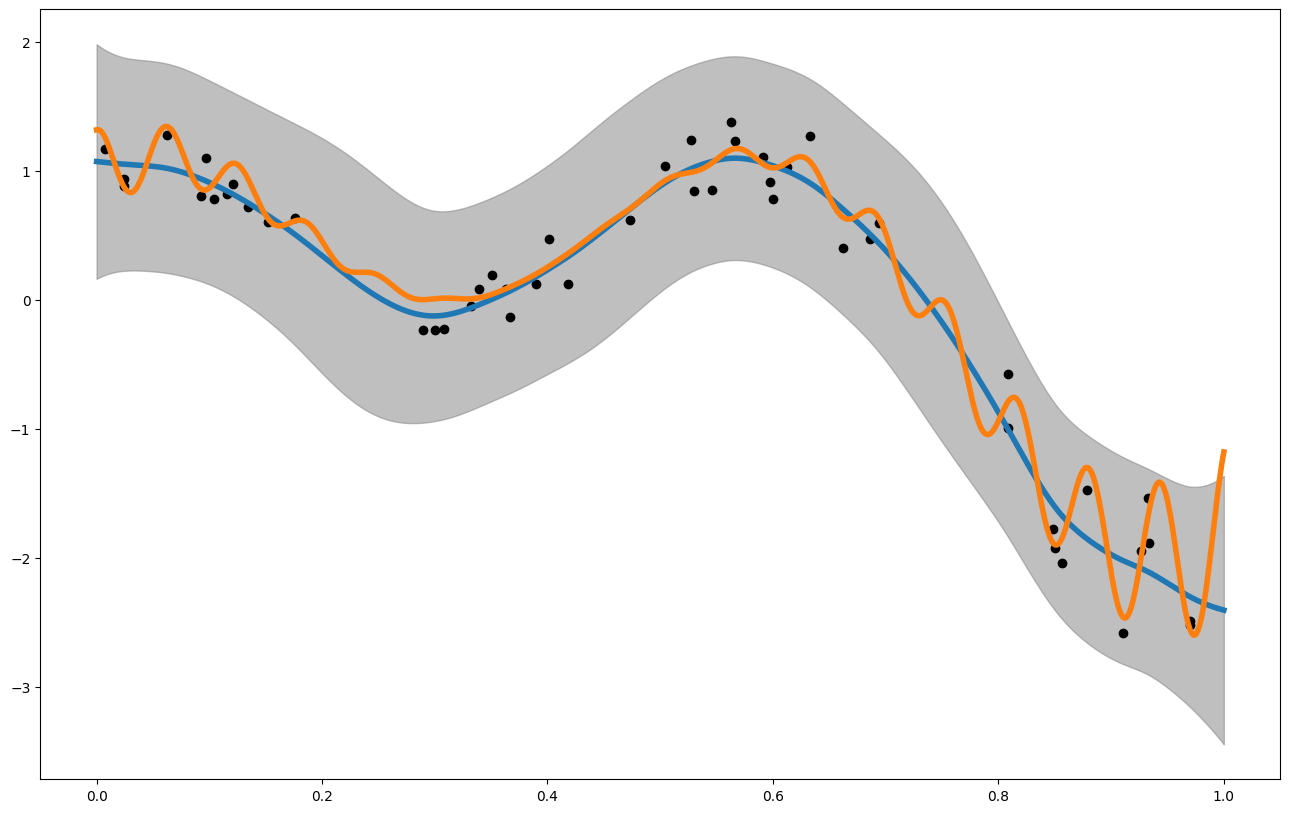

In [10]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gpo.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gpo.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gpo.rmse(x_pred1D,f1(x_pred1D)))
print(my_gpo.crps(x_pred1D,f1(x_pred1D)))

In [11]:
#available acquisition function for the single-task case:
acquisition_functions = ["variance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "probability of improvement", "target probability", "total correlation"]

Acquisition function  variance
Acquisition function  relative information entropy
Some acquisition function return a scalar score for the entirety of points. Here:  relative information entropy
Acquisition function  relative information entropy set
Acquisition function  ucb
Acquisition function  lcb
Acquisition function  maximum
Acquisition function  minimum
Acquisition function  gradient
Acquisition function  expected improvement
Acquisition function  probability of improvement
Acquisition function  target probability
Acquisition function  total correlation
Some acquisition function return a scalar score for the entirety of points. Here:  total correlation


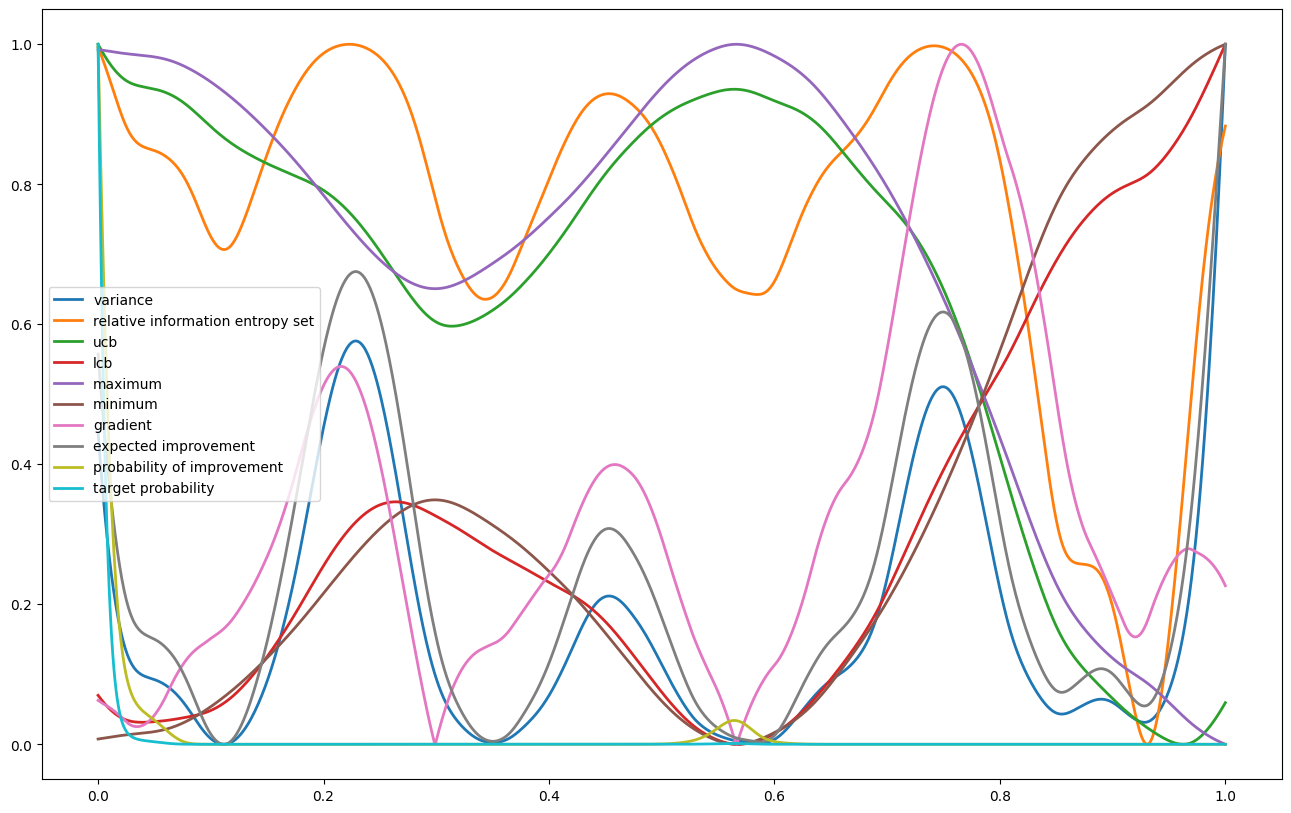

In [12]:
plt.figure(figsize=(16,10))
for acq_func in acquisition_functions:
    print("Acquisition function ",acq_func)
    res = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function=acq_func)
    if len(res)==len(x_pred):
        res = res - np.min(res)
        res = res/np.max(res)
        plt.plot(x_pred,res, label = acq_func, linewidth = 2)
    else: print("Some acquisition function return a scalar score for the entirety of points. Here: ", acq_func)
plt.legend()
plt.show()


## ask()ing for Optimal Evaluations
with several optimization methods and acquisition functions

In [13]:
#let's test the asks:
bounds = np.array([[0.0,1.0]])
for acq_func in acquisition_functions:
    for method in ["global","local","hgdl"]:
        print("Acquisition function ", acq_func," and method ",method)
        new_suggestion = my_gpo.ask(bounds, acquisition_function=acq_func, 
                                    method=method, max_iter = 2, dask_client=client)
        print("led to new suggestion: \n", new_suggestion)
        print("")


Acquisition function  variance  and method  global
led to new suggestion: 
 {'x': array([[0.23126739]]), 'f_a(x)': array([0.03790421]), 'opt_obj': None}

Acquisition function  variance  and method  local
led to new suggestion: 
 {'x': array([[0.74564796]]), 'f_a(x)': array([0.03450045]), 'opt_obj': None}

Acquisition function  variance  and method  hgdl
led to new suggestion: 
 {'x': array([[0.22855429]]), 'f_a(x)': array([0.03796816]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f408ed76800>}

Acquisition function  relative information entropy  and method  global
led to new suggestion: 
 {'x': array([[0.73127453]]), 'f_a(x)': array([-34.24433787]), 'opt_obj': None}

Acquisition function  relative information entropy  and method  local
led to new suggestion: 
 {'x': array([[0.]]), 'f_a(x)': array([-33.95346034]), 'opt_obj': None}

Acquisition function  relative information entropy  and method  hgdl
led to new suggestion: 
 {'x': array([[0.]]), 'f_a(x)': array([-33.95346034]), 'opt_obj': <h

In [14]:
#here we can test other options of the ask() command
bounds = np.array([[0.0,1.0]])
new_suggestion = my_gpo.ask(bounds, acquisition_function="total_correlation", method="global",
                            max_iter=10, n = 5, info = True)
my_gpo.ask(bounds, n = 5, acquisition_function="variance", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 1, acquisition_function="relative information entropy", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 2, acquisition_function="expected improvement", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 1, acquisition_function="variance", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 3, acquisition_function="variance", vectorized=True, method = 'hgdl', dask_client=client)
print(new_suggestion)

differential_evolution step 1: f(x)= 18.475258216229843
differential_evolution step 2: f(x)= 18.475258216229843
differential_evolution step 3: f(x)= 18.475258216229843


/home/marcus/Coding/gpCAM/gpcam/gp_optimizer_base.py:391: UserWarning: You specified n>1 and method != 'hgdl' in ask(). The acquisition function has therefore been changed to 'total correlation'.
  warnings.warn("You specified n>1 and method != 'hgdl' in ask(). The acquisition function "


differential_evolution step 4: f(x)= 18.475258216229843
differential_evolution step 5: f(x)= 18.475258216229843
differential_evolution step 6: f(x)= 18.475258216229843
differential_evolution step 7: f(x)= 18.475258216229843
differential_evolution step 8: f(x)= 18.475258216229843
differential_evolution step 9: f(x)= 17.39362923600883
differential_evolution step 10: f(x)= 17.39362923600883
{'x': array([[0.71722964],
       [0.45174786],
       [0.74415767],
       [0.77179673],
       [0.99454892]]), 'f_a(x)': array([-17.39362924]), 'opt_obj': None}


In [15]:
#we can evaluate the acqisiiton function on batches of candidates in parallel:
candidates = np.random.uniform(low = bounds[:,0], high=bounds[:,1], size = (30,1))
candidate_list = [entry for entry in candidates]


In [16]:
#ask sequentially
print("suggestions=", my_gpo.ask(candidate_list, n = 30, acquisition_function="variance", vectorized=False)["x"][0])
#ask in parallel on DASK workers, but sequentially on each worker:
print("suggestions=", my_gpo.ask(candidate_list, n = 30, acquisition_function="variance", vectorized=False, batch_size = 10, dask_client=client)["x"][0])
#ask in parallel on DASK workers, and vectorized (if possible) on each worker:
print("suggestions=", my_gpo.ask(candidate_list, n = 30, acquisition_function="variance", vectorized=True, batch_size = 10, dask_client=client)["x"][0])
#ask vectorized (if possible):
print("suggestions=", my_gpo.ask(candidate_list, n = 30, acquisition_function="variance", vectorized=True)["x"][0])
print("They should be the same!")

suggestions= [0.22957534]
suggestions= [0.22957534]
suggestions= [0.22957534]
suggestions= [0.22957534]
They should be the same!


In [17]:
bounds = np.array([[0.0,1.0]])

#You can even start an ask() search asynchronously and check back later what was found
new_suggestion = my_gpo.ask(bounds, acquisition_function=acquisition_functions[0], method="hgdlAsync", dask_client=client)
time.sleep(10)
print(new_suggestion["opt_obj"])
#And we have to cancel that trainig and possibly kill the client
new_suggestion["opt_obj"].kill_client()

[{'x': array([0.22855382]),
  'f(x)': np.float64(-0.03796815855677371),
  'classifier': 'minimum',
  'Hessian eigvals': array([17.36077948]),
  'df/dx': array([-3.42881279e-06]),
  '|df/dx|': np.float64(3.4288127892523335e-06),
  'radius': np.float64(0.057601100291234955)},
 {'x': array([0.74953491]),
  'f(x)': np.float64(-0.034623009399779026),
  'classifier': 'minimum',
  'Hessian eigvals': array([16.25988233]),
  'df/dx': array([-1.54476432e-05]),
  '|df/dx|': np.float64(1.5447643164634428e-05),
  'radius': np.float64(0.061501060077709294)},
 {'x': array([0.45327907]),
  'f(x)': np.float64(-0.019327868525446767),
  'classifier': 'minimum',
  'Hessian eigvals': array([8.03224154]),
  'df/dx': array([-6.13855633e-05]),
  '|df/dx|': np.float64(6.138556329915446e-05),
  'radius': np.float64(0.12449824811661679)}]